# Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings
warnings.simplefilter('ignore', 'r')

# Data

In [63]:
credit = pd.read_csv('credit_card_transaction_flow.csv')
display(credit.head())
display(credit.info())

,Customer ID,Name,Surname,Gender,Birthdate,Transaction Amount,Date,Merchant Name,Category
0,752858,Sean,Rodriguez,F,20-10-2002,35.47,03-04-2023,Smith-Russell,Cosmetic
1,26381,Michelle,Phelps,NaN,24-10-1985,2552.72,17-07-2023,"Peck, Spence and Young",Travel
2,305449,Jacob,Williams,M,25-10-1981,115.97,20-09-2023,Steele Inc,Clothing
3,988259,Nathan,Snyder,M,26-10-1977,11.31,11-01-2023,"Wilson, Wilson and Russell",Cosmetic
4,764762,Crystal,Knapp,F,02-11-1951,62.21,13-06-2023,Palmer-Hinton,Electronics


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         50000 non-null  int64  
 1   Name                50000 non-null  object 
 2   Surname             50000 non-null  object 
 3   Gender              44953 non-null  object 
 4   Birthdate           50000 non-null  object 
 5   Transaction Amount  50000 non-null  float64
 6   Date                50000 non-null  object 
 7   Merchant Name       50000 non-null  object 
 8   Category            50000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 3.4+ MB


None

In [64]:
credit[['B_Day', 'B_Month', 'B_Year']] = credit['Birthdate'].str.split('-', expand=True)
credit[['D_Day', 'D_Month', 'D_Year']] = credit['Date'].str.split('-', expand=True)

credit[['B_Day', 'B_Month', 'B_Year', 'D_Day', 'D_Month', 'D_Year']] = credit[['B_Day', 'B_Month', 'B_Year', 'D_Day', 'D_Month', 'D_Year']].astype('int64')
credit = credit.drop(['Birthdate', 'Date', 'Customer ID'], axis=1)

In [ ]:
def nan_count(df):
    nan_count = []
    nan_pct = []
    for col in credit.columns:
        nan_count.append(credit[col].isnull().sum())
        nan_pct.append(np.round(credit[col].isnull().sum()/len(credit.index), decimals=2))
    temp_df = pd.DataFrame({'col_name': credit.columns, 'nan_count': nan_count, 'nan_pct': nan_pct})
    return temp_df

nan_count(credit)

In [ ]:
def unique_count(df):
    unique_count = []
    unique_val = []
    for col in df.columns:
        unique_count.append(df[col].nunique())
        unique_val.append(df[col].unique())
        
    temp_df = pd.DataFrame({'col_name': df.columns, 'unique_count': unique_count, 'unique_val': unique_val})
    
    return temp_df

unique_count(credit)

# EDA

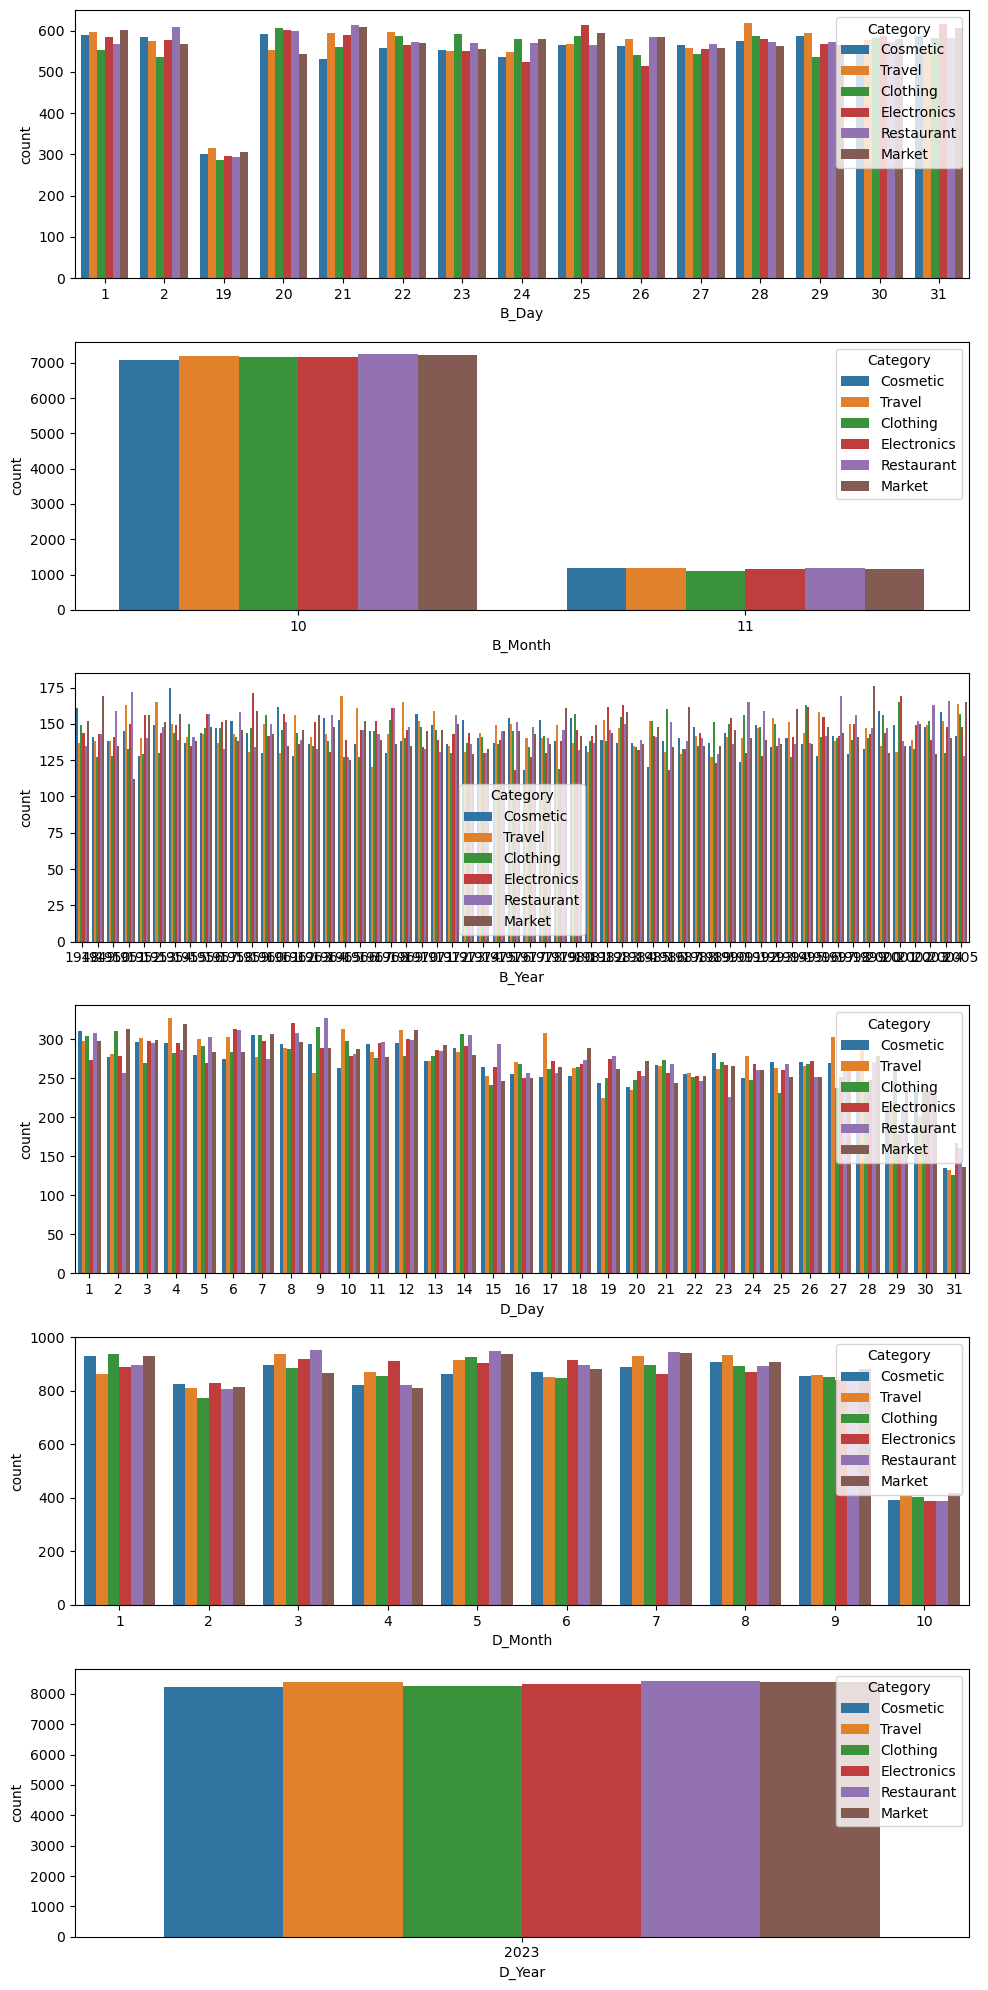

In [65]:
date_feat = ['B_Day', 'B_Month', 'B_Year', 'D_Day', 'D_Month','D_Year']

fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(10,20))
axs = axs.flatten()
for i, feat in enumerate(date_feat):
    sns.countplot(x=feat, data=credit, hue='Category', ax=axs[i])

fig.tight_layout()
plt.show()

It seems like the B_Month, B_Day, D_Year don't have correlation with category

In [66]:
credit = credit.drop(['B_Month', 'B_Day', 'D_Year'], axis=1)

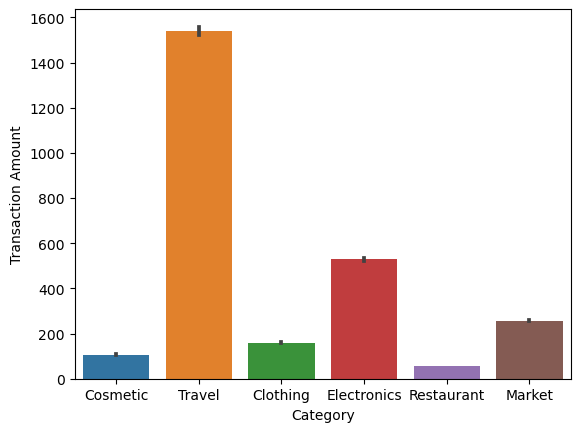

In [72]:
cont_feature = 'Transaction Amount'

sns.barplot(x='Category', y=cont_feature, data=credit)
plt.show()

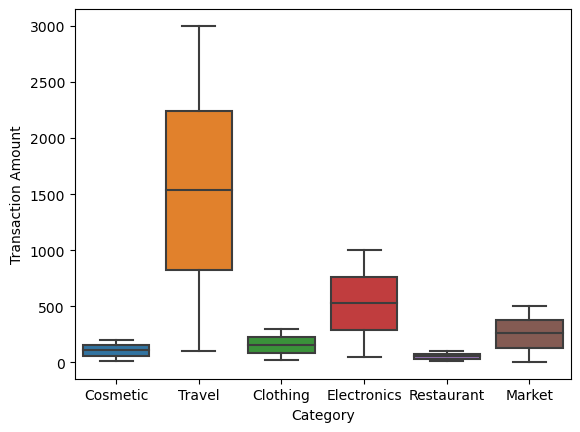

In [74]:
sns.boxplot(x='Category', y=cont_feature, data=credit)
plt.show()

<Axes: xlabel='Gender', ylabel='count'>

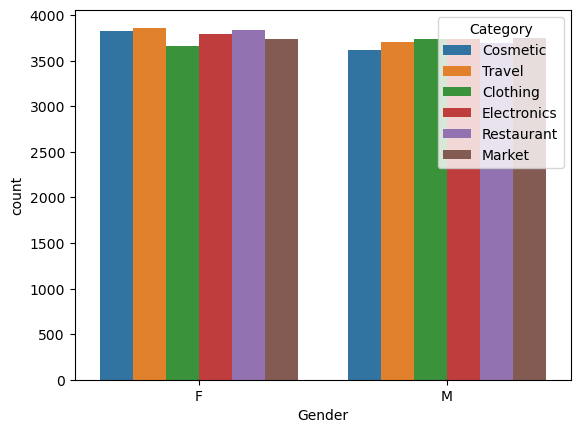

In [76]:
sns.countplot(x='Gender', data=credit, hue='Category')

# Missing Values Process

In [78]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder

In [79]:
credit_copy = credit

def label_encoder(df):
    for col in df.select_dtypes('object').columns:
        label = LabelEncoder()
        label.fit(df[col].unique())
        df[col] = label.transform(df[col])
    return df
credit_copy = label_encoder(credit_copy)
credit = label_encoder(credit)

X_pred = credit_copy[credit_copy['Gender']==2][['Name', 'Surname']]
                                          
X_train1 = credit_copy[credit_copy['Gender']!=2][['Name', 'Surname']]
y_train1 = credit_copy[credit_copy['Gender']!=2]['Gender']                                               

In [80]:
xgb = XGBClassifier(random_state=10, eval_metric='logloss')

boosted_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [4, 8, 12],
    'learning_rate': [0.05, 0.1, 0.15]
}

kf = KFold(n_splits=5, shuffle=True, random_state=10)

clf = GridSearchCV(xgb, param_grid=boosted_grid, cv=kf)
clf.fit(X_train1, y_train1)
clf.best_params_

{'learning_rate': 0.15, 'max_depth': 12, 'n_estimators': 200}

In [81]:
xgb = XGBClassifier(max_depth=12, learning_rate=0.15, n_estimators=200, random_state=10, eval_metric='logloss')
xgb.fit(X_train1, y_train1)
y_pred1 = xgb.predict(X_pred)

credit['Gender'] = credit['Gender'].replace(2, np.nan)
credit['Gender'] = credit['Gender'].fillna(pd.Series(y_pred1, index=credit[credit['Gender'].isna()].index))

<Axes: >

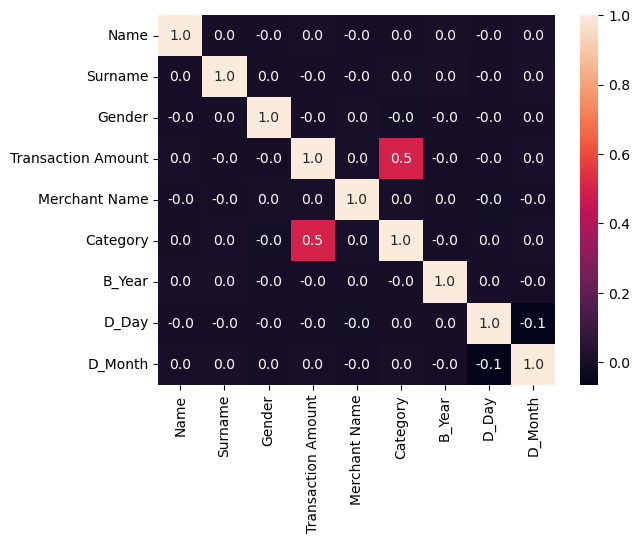

In [85]:
sns.heatmap(credit.corr(), fmt='.1f', annot=True)

# Data Prepare

In [95]:
from sklearn.model_selection import train_test_split

X = credit.drop(['Category'], axis=1)
y = credit['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Model Selection

In [87]:
#from xgboost import XGBClassifier (takes too long)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


dtree = DecisionTreeClassifier(random_state=10)
rf = RandomForestClassifier(random_state=10)

model_cv = {
    #'XGBClassifier': XGBClassifier(random_state=10, eval_metric='logloss'),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=10),
    'RandomForestClassifier': RandomForestClassifier(random_state=10),
}

dtree_grid = {
    'max_depth' : [3, 5, 7, 9],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features' : ['sqrt', 'log2']
}

rf_grid = {
    'n_estimators' : [50, 100, 150, 200]
}

boosted_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [4, 8, 12],
    'learning_rate': [0.05, 0.1, 0.15]
}

grid = {
    'DecisionTreeClassifier' : dtree_grid,
    'RandomForestClassifier' : rf_grid,
    #'XGBClassifier': boosted_grid
}

In [99]:
best_param = []
score = []
for model in model_cv.keys():
    clf = GridSearchCV(model_cv[model], param_grid=grid[model], cv=kf)
    clf.fit(X_train, y_train)
    best_param.append(clf.best_params_)
    score.append(clf.score(X_test, y_test))

param_df = pd.DataFrame({'model': model_cv.keys(), 'best_param': best_param, 'score': score })
display(param_df)

,model,best_param,score
0,DecisionTreeClassifier,"{'max_depth': 9, 'max_features': 'log2', 'min_...",0.5793
1,RandomForestClassifier,{'n_estimators': 200},0.5750


## XGBoostClassifier 

In [13]:
"""xgb = XGBoostClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb.score(y_pred_xgb, y_test)"""

'xgb = XGBoostClassifier()\nxgb.fit(X_train, y_train)\ny_pred_xgb = xgb.predict(X_test)\nxgb.score(y_pred_xgb, y_test)'

## DecisionTreeClassifier

In [101]:
from sklearn.metrics import accuracy_score
dtree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=10, max_features='log2' ,random_state=10)
dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_test)

accuracy_score(y_pred_dtree, y_test)

0.5793

## RandomForestClassifier

In [98]:
rf = RandomForestClassifier(n_estimators= 200, random_state=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy_score(y_pred_rf, y_test)

0.575

## KNeighborsClassifier

In [102]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

accuracy_score(y_pred_knn, y_test)

0.4415

# GaussianNB

In [103]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

accuracy_score(y_pred_gnb, y_test)

0.5402